# Generating Correct Names
#### Rules
- 3 words
- First word can be male/female
- Second and third words must be males

In [ ]:
from typing import List
import pandas as pd
import random
import string

from collections import Counter
from tqdm import tqdm

random.seed(23)

## Generate 2000 coorect names

In [4]:
names_df = pd.read_csv("data/Arabic_names.csv")
print(names_df.shape)
names_df.sample(10)

(1405, 2)


,Name,Gender
707,حجاب,M
247,زهراء,F
630,باسق,M
1326,نافع,M
563,أجاويد,M
597,أكرم,M
595,أكبر,M
1314,نائل,M
590,أشيم,M
1247,مشرف,M


In [6]:
male_names = names_df[names_df.Gender=='M']['Name'].tolist()
female_names = names_df[names_df.Gender=='F']['Name'].tolist()

In [7]:
def generate_fullnames(male_names: List[str], female_list: List[str] = None, num_names = 1000) -> List[str]:
    """
    Generates full names where second and third names must always be males.
    """
    names = []

    for _ in range(num_names):
        # males
        names.append(" ".join(random.sample(male_names, 3)))
        # females
        if female_list:
            names.append(random.sample(female_names, 1)[0] + " " + " ".join(random.sample(male_names, 2)))
    
    return names

In [8]:
names = generate_fullnames(male_names, female_names, 50000)
print(f"Number of names generated: {len(names)}")
names[:3]

Number of names generated: 100000


['نصر ساعف ياسر', 'إيمان أخطب قطامي', 'سعيد عبدالرشيد ضياء']

In [9]:
pd.DataFrame(names, columns=["Name"]).to_csv("data/full_correct_names.csv", index=None)

In [10]:
temp_df = pd.read_csv("data/full_correct_names.csv")
temp_df.head()

,Name
0,نصر ساعف ياسر
1,إيمان أخطب قطامي
2,سعيد عبدالرشيد ضياء
3,ولهانة صادر جرير
4,منتظر داني زاكي


### Stats about our names 

In [11]:
temp_df['Name'].str.split().map(len)

0        3
1        3
2        3
3        3
4        3
        ..
99995    3
99996    3
99997    3
99998    3
99999    3
Name: Name, Length: 100000, dtype: int64

(Max, Min, Mean)


(5, 3, 3.02392)

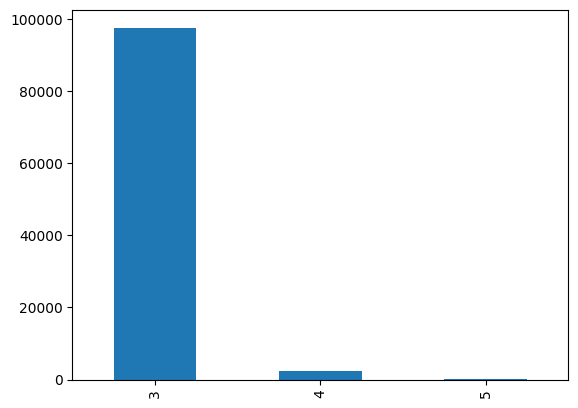

In [12]:
temp_df['Name'].str.split().map(len).value_counts().plot.bar()
print("(Max, Min, Mean)")
temp_df['Name'].str.split().map(len).max(), temp_df['Name'].str.split().map(len).min(), temp_df['Name'].str.split().map(len).mean()

# Generating Bad Names
generate individual full names:
- total garbage - 500
  - we can randomly shuffle the correct names
- mistype names - 500
  - repeat random characters
- other correct words but not names - 500
- mix of all of above - 500

### Helper functions 

### Generate names with repeated characters between 1, 2

In [13]:
def repeat_characters(name: str, num_repeats: int) -> str:
    """
    Repeat random characters for a num of repeats, randomly turned off(to reduce the number of repeats) so words are not recognizably long.
    """
    new_name: str = ""
    for idx, ch in enumerate(name):
        if random.randint(0, 1):
            reps = num_repeats
        else:
            reps = 1
        new_name += ch * random.randint(1, reps)
    
    return new_name

In [14]:
repeat_characters("مريم", 2)

'مريم'

In [15]:
repeated_names = []
for name in names_df.iloc[:, 0].values:
    repeated_names.append(repeat_characters(name, 3))
    
repeated_names[:10]

['ابتتسسسااام',
 'ااابتتهاج',
 'ااابتهال',
 'اججتهاد',
 'ازدهاااررر',
 'اععتتتدال',
 'اعععتماااد',
 'افتخاررر',
 'افتكار',
 'البتووول']

### Get some random but correct words from the internet

In [16]:
df = pd.read_csv("data/ar_reviews_100k.tsv", sep="\t")
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [17]:
word_counter = Counter()

for sent in tqdm(df.iloc[:, 1], total=df.shape[0]):
    # remove Punctuation first
    sent = sent.translate(str.maketrans('', '', string.punctuation))
    word_counter.update(sent.split())

print(f"Number of words: {len(word_counter)}")
some_common_words = word_counter.most_common()[10_000: 15_000]
some_common_words = [i[0] for i in some_common_words]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99999/99999 [00:03<00:00, 26586.93it/s]

Number of words: 351992


### Total Garabage

In [18]:
garbage_names = []

for name in names_df.iloc[:, 0].values:
    name = list(name)
    random.shuffle(name)
    garbage_names.append("".join(name))
    
garbage_names[:10]

['بساتام',
 'ابهتجا',
 'بالاهت',
 'اتهجاد',
 'رزهااد',
 'عالتدا',
 'تداعام',
 'خرافات',
 'تفاارك',
 'اللبوت']

## Generating Bad Names
- [x] total garbage
- [x] repeated
- [x] correct words but not names
- [x] mix bad names
- [x] mix good and bad names
    - 1 or 2 good names

In [19]:
def generate_mix(bad_names: List[str], good_names: List[str], num_names: int = 500) -> List[str]:
    """
    Generate 3-words names that have 1 or 2 correct names in it.
    """
    
    names = []
    for _ in range(num_names):
        # pick 1 or 2 good names
        num_good = random.randint(1, 2)
        num_bad = 3 - num_good

        name_words = []
        name_words.extend(random.sample(good_names, num_good)) # good names
        name_words.extend(random.sample(bad_names, num_bad)) # bad names
        random.shuffle(name_words)
        names.append(" ".join(name_words))
        
    return names

In [21]:
# garbage
n = 16000

bad_names = []
bad_names.extend(generate_fullnames(garbage_names, num_names=n))

# repeated
bad_names.extend(generate_fullnames(repeated_names, num_names=n))

# correct but not names
bad_names.extend(generate_fullnames(some_common_words, num_names=n))

# mix bad names
bad_names.extend(generate_fullnames(garbage_names+repeated_names+some_common_words, num_names=n))

# mix good and bad names
bad_names.extend(generate_mix(garbage_names+repeated_names+some_common_words, male_names+female_names, num_names=n))

print(f"Number of bad names: {len(bad_names)}")

Number of bad names: 80000


In [22]:
pd.DataFrame(bad_names, columns=["Name"]).to_csv("data/full_bad_names.csv", index=None)

In [23]:
temp_df = pd.read_csv("data/full_bad_names.csv")
temp_df.sample(5)

,Name
52231,فكرتني فففؤؤااد أممااني
61015,هراض ويقدم وصخه
13846,رينك يلاعبدابق عفرا
20282,شعيب حسسن ععببااادد
60940,خويييلد سفرا ولاد


# Making the Dataset

In [24]:
df_correct = pd.read_csv("data/real_names.csv")
df_incorrect = pd.read_csv("data/full_bad_names.csv")

In [25]:
full_df = df_correct.copy()
full_df['class'] = 1
full_df = pd.concat([full_df, df_incorrect], ignore_index=True)
full_df.fillna(0, inplace=True)
full_df

,Name,class
0,هبه على محمد,1.0
1,يمنى حمدونه سليمان,1.0
2,حبيبه ابو زيد,1.0
3,شهد اسامه حسانين,1.0
4,رحمه سامح فاروق,1.0
...,...,...
160880,هيفاء وديعة الجرائد,0.0
160881,فحيت سعيد وحزن,0.0
160882,التفكر شكري الجازي,0.0
160883,أكبر معروف غالبية,0.0


In [27]:
full_df.to_csv("data/real_correct_generated_bad.csv", index=False)
temp_df = pd.read_csv("data/real_correct_generated_bad.csv")
print(temp_df.shape)
temp_df.sample(5)

(160885, 2)


,Name,class
99959,ااالريممم ععبدااالههادي ررهييفةةة,0.0
96358,عةارب ويرشد يانسإ,0.0
47753,سيف سمير نبيه,1.0
84070,انرز ةطمحا رمساي,0.0
77926,محمد شريف حسن,1.0
